In [189]:
import math
from datetime import timedelta, datetime

import pandas as pd
import matplotlib.pyplot as plt

In [251]:
df = pd.read_csv('data/tracking_data.csv')
df["time"] = pd.to_datetime(df['time'] * 10**9)

l = len(df)
df = df.drop_duplicates(['time', 'event_type'])
print(f'dropped {l - len(df)} duplicates')
df

dropped 24742 duplicates


,event_type,button,x,y,delta,time
0,blink,NaN,NaN,NaN,95.0,2023-09-16 23:05:24.683823104
1,yawn,NaN,NaN,NaN,2.0,2023-09-16 23:05:24.685051392
2,move,NaN,815.0,604.0,NaN,2023-09-16 23:06:17.096880896
3,move,NaN,761.0,618.0,NaN,2023-09-16 23:06:17.104868864
4,move,NaN,724.0,626.0,NaN,2023-09-16 23:06:17.112872704
...,...,...,...,...,...,...
253626,move,NaN,893.0,328.0,NaN,2023-09-17 02:08:40.057357312
253627,move,NaN,893.0,328.0,NaN,2023-09-17 02:08:40.058412288
253628,move,NaN,893.0,328.0,NaN,2023-09-17 02:08:40.065416192
253629,move,NaN,892.0,328.0,NaN,2023-09-17 02:08:40.080464896


In [242]:
_df: pd.DataFrame = df.copy()

rows = _df.to_dict('records')
rows

[{'event_type': 'blink',
  'button': nan,
  'x': nan,
  'y': nan,
  'delta': 95.0,
  'time': Timestamp('2023-09-16 23:05:24.683823104')},
 {'event_type': 'yawn',
  'button': nan,
  'x': nan,
  'y': nan,
  'delta': 2.0,
  'time': Timestamp('2023-09-16 23:05:24.685051392')},
 {'event_type': 'move',
  'button': nan,
  'x': 815.0,
  'y': 604.0,
  'delta': nan,
  'time': Timestamp('2023-09-16 23:06:17.096880896')},
 {'event_type': 'move',
  'button': nan,
  'x': 761.0,
  'y': 618.0,
  'delta': nan,
  'time': Timestamp('2023-09-16 23:06:17.104868864')},
 {'event_type': 'move',
  'button': nan,
  'x': 724.0,
  'y': 626.0,
  'delta': nan,
  'time': Timestamp('2023-09-16 23:06:17.112872704')},
 {'event_type': 'move',
  'button': nan,
  'x': 697.0,
  'y': 634.0,
  'delta': nan,
  'time': Timestamp('2023-09-16 23:06:17.119873792')},
 {'event_type': 'move',
  'button': nan,
  'x': 668.0,
  'y': 637.0,
  'delta': nan,
  'time': Timestamp('2023-09-16 23:06:17.127866624')},
 {'event_type': 'move',
  

In [243]:
print(f"{len(rows)} rows")

trajectory_i = -1
_rows = rows.copy()
filtered_trajectories = []
trajectory_begin = None
for i, row in enumerate(rows):
    _rows[i]['trajectory'] = trajectory_i
    row['time'] = row['time'].to_pydatetime()
    
    
    if not trajectory_begin:  # first record of trajectory
        trajectory_begin = row['time']
    if row['event_type'] != 'move':  # click / scroll
        if timedelta(seconds=1) < row['time'] - trajectory_begin < timedelta(seconds=10):
           filtered_trajectories.append(trajectory_i)
        trajectory_i += 1
        trajectory_begin = None
       
print(f"found {len(filtered_trajectories)} good trajectories")       

rows = _rows 
_rows = []
trajectory_i = 0
prev = -1
for row in rows:
    if row['trajectory'] in filtered_trajectories:
        if prev != row['trajectory']:
            prev = row['trajectory']
            trajectory_i += 1
            
        row['trajectory'] = trajectory_i
        _rows.append(row)

rows = _rows
print(f"{len(rows)} rows")

147248 rows


C:\Users\iliaz\AppData\Local\Temp\ipykernel_20756\3255062157.py:9: UserWarning: Discarding nonzero nanoseconds in conversion.
  row['time'] = row['time'].to_pydatetime()


found 713 good trajectories
86899 rows


In [244]:
trajectory_i = 0
i = 0

trajectories = []

while i < len(rows):
    i0 = i
    i += 1  # to enable computations on i-1
    avg_speed = 0
    prev_time = rows[i0]['time']
    points_x = [rows[i0]['x']]
    points_y = [rows[i0]['y']]
    
    while i < len(rows) and rows[i]['event_type'] == 'move':  # rows[i]['trajectory'] == trajectory_i and
        avg_speed += math.sqrt((rows[i]['x'] - rows[i-1]['x']) ** 2 + (rows[i]['y'] - rows[i-1]['y']) ** 2) \
                     / (rows[i]['time'] - rows[i-1]['time']).microseconds * 10 ** 6
        
        timepoint = prev_time + timedelta(milliseconds=300)
        while rows[i]['time'] >= timepoint:
            coef = (timepoint - rows[i-1]['time']) / (rows[i]['time'] - rows[i-1]['time'])
            points_x.append(rows[i-1]['x'] + coef * (rows[i]['x'] - rows[i-1]['x']))
            points_y.append(rows[i-1]['y'] + coef * (rows[i]['y'] - rows[i-1]['y']))
            prev_time = timepoint
            timepoint = prev_time + timedelta(milliseconds=300)
            
        i += 1
        
    eqdir = []
    for j in range(1, len(points_x)-1):
        eqdir.append(int((points_x[j] - points_x[j-1] > 0) == (points_x[j+1] - points_x[j] > 0) \
                     and (points_y[j] - points_y[j-1] > 0) == (points_y[j+1] - points_y[j] > 0)))
    
    if eqdir:  # otherwise e.g. the movement itself was short, then a small pause and a click
        accuracy = sum(eqdir) / len(eqdir)
        
        n_events = i - i0
        avg_speed = avg_speed / n_events
        trajectories.append({'id': trajectory_i,
                             'start': rows[i0]['time'],
                             'end': rows[i]['time'],
                             'speed': avg_speed,
                             'accuracy': accuracy})
    
    i += 1  # account for click/scroll event in the end of trajectory
    trajectory_i += 1
    

In [245]:
df = pd.DataFrame(trajectories)
df['stress'] = - df['speed'] * df['accuracy'] + 3000
df

,id,start,end,speed,accuracy,stress
0,0,2023-09-16 23:06:17.096880,2023-09-16 23:06:26.083621,1366.468423,0.714286,2023.951127
1,1,2023-09-16 23:06:29.682965,2023-09-16 23:06:30.857300,1802.908314,0.000000,3000.000000
2,2,2023-09-16 23:06:31.235031,2023-09-16 23:06:32.811248,2405.245890,0.000000,3000.000000
3,3,2023-09-16 23:06:36.039983,2023-09-16 23:06:38.157563,663.094687,0.750000,2502.678985
4,4,2023-09-16 23:06:38.653851,2023-09-16 23:06:40.895849,1275.605362,0.600000,2234.636783
...,...,...,...,...,...,...
686,708,2023-09-17 01:29:41.211590,2023-09-17 01:29:42.719909,184.912269,0.250000,2953.771933
687,709,2023-09-17 01:29:42.727449,2023-09-17 01:29:43.926816,241.952582,0.500000,2879.023709
688,710,2023-09-17 01:29:44.031065,2023-09-17 01:29:48.662804,391.580055,0.857143,2664.359953
689,711,2023-09-17 01:29:53.242356,2023-09-17 01:29:55.043484,257.454723,0.000000,3000.000000


C:\Users\iliaz\AppData\Local\Temp\ipykernel_20756\4293466802.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  time_s = time_s.groupby(pd.Grouper(key='start', freq='3Min')).mean()['stress'].rolling(10, min_periods=3).mean()


<Axes: xlabel='start'>

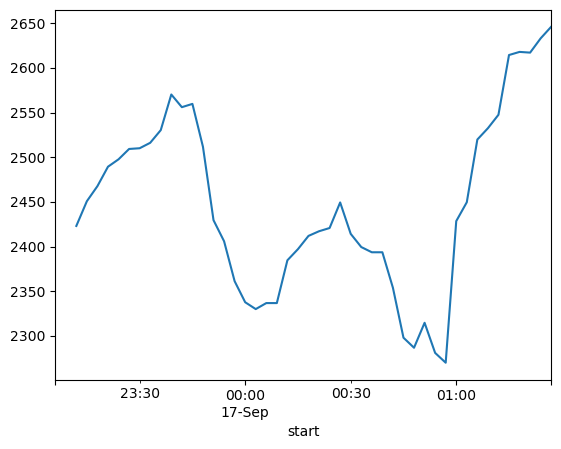

In [250]:
time_s = df#[(df['event_type'] == 'blink') | (df['event_type'] == 'yawn')]#.set_index('time')#.iloc[:1000, :].pivot(index='time', columns='x').resample('T').count()
#time_s1 = time_s[df['event_type'] == 'blink'].groupby(pd.Grouper(key='time', freq='3Min')).mean()['delta']#[['speed', 'accuracy']]

time_s = time_s.groupby(pd.Grouper(key='start', freq='3Min')).mean()['stress'].rolling(10, min_periods=3).mean()
time_s.plot()

In [236]:
ts: pd.Series = time_s.iloc[-3:]
ts.tolist()

[2611.488461244174, 2563.934723992198, 2553.596473858392]

C:\Users\iliaz\AppData\Local\Temp\ipykernel_20756\3350518052.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  time_s1 = df[df['event_type'] == 'blink'].groupby(pd.Grouper(key='time', freq='3Min')).mean()['delta'].rolling(10, min_periods=3).mean()#[['speed', 'accuracy']]


<Axes: xlabel='time'>

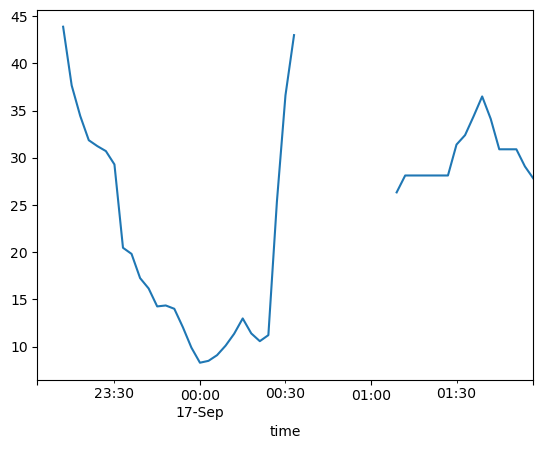

In [256]:
time_s1 = df[df['event_type'] == 'blink'].groupby(pd.Grouper(key='time', freq='3Min')).mean()['delta'].rolling(10, min_periods=3).mean()#[['speed', 'accuracy']]
time_s1.plot()

In [253]:
(-time_s['accuracy']*time_s['speed'] + 3000).plot()


KeyError: 'accuracy'

In [ ]:
df